### Visualization of landmark centering

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Przejście do katalogu głównego
%cd /content

# Klonowanie repo
!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [3]:
# Upewnij się, że nazwa użytkownika i repozytorium są poprawne
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

# Tworzenie poprawnego adresu URL (format: https://<TOKEN>@github.com/...)
REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

# Klonowanie
!git clone {REPO_URL}

# Wejście do katalogu
%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 148 (delta 56), reused 119 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (148/148), 8.78 MiB | 9.32 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/automatic-pain-recognition


In [4]:
# Instalacja wymaganych bibliotek
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [4]:
import sys
import os

# Dodaj katalog główny projektu do ścieżki systemowej
sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### MediaPipe Compatibility Fix (Python 3.12+ / January 2026)
Note: Since the Google Colab update in early 2026, MediaPipe has changed its package structure. If you encounter AttributeError: module 'mediapipe' has no attribute 'solutions' or ModuleNotFoundError, please run the two cells below.

In [ ]:
# 1. Czyszczenie starego bałaganu
!pip uninstall -y mediapipe
!rm -rf /usr/local/lib/python3.12/dist-packages/mediapipe

# 2. Instalacja wersji zgodnej z 3.12 (bez cache)
!pip install --no-cache-dir mediapipe==0.10.14

# 3. WYMUSZENIE RESTARTU - to zabije sesję i odświeży ścieżki
import os
os.kill(os.getpid(), 9)

Found existing installation: mediapipe 0.10.31
Uninstalling mediapipe-0.10.31:
  Successfully uninstalled mediapipe-0.10.31
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 167.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 200.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


### Centering

In [5]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# Dlib functions (function-based module)
from data_preparation.processing_pipeline_dlib import (
    init_dlib,
    process_frame as dlib_process_frame,
    landmark_obj_to_array,
    center_by_reference
)

# MediaPipe functions (function-based module)
from data_preparation.processing_pipeline_mediapipe import (
    create_face_mesh,
    load_reference_keypoints,
    process_frame as mp_process_frame,
    visualize_raw_detection,
    visualize_frontalized_points,
    parse_landmarks_from_results,
    center_keypoints
)


print("Imports successful!")

Imports successful!


In [7]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
VIDEO_SAMPLE_PATH = os.path.join(COLAB_ROOT, 'data/BioVid_HeatPain/071309_w_21', '071309_w_21-BL1-081.mp4')

In [8]:
cap = cv2.VideoCapture(VIDEO_SAMPLE_PATH)
ret, sample_frame = cap.read()
cap.release()

if ret:
    print(f"Sample frame loaded: {sample_frame.shape}")
else:
    print("ERROR: Could not load video")


Sample frame loaded: (1038, 1388, 3)


#### Dlib

In [9]:
PREDICTOR_PATH = os.path.join(COLAB_ROOT, 'data', 'shape_predictor_68_face_landmarks.dat')
MEAN_FACE_PATH = os.path.join(COLAB_ROOT, 'data', 'landmarks_mean_face.npy')
WEIGHTS_PATH = os.path.join(COLAB_ROOT, 'data', 'frontalization_weights.npy')

dlib_ctx = init_dlib(PREDICTOR_PATH, MEAN_FACE_PATH, WEIGHTS_PATH)
print(
    "Dlib ready; frontalization weights available:",
    dlib_ctx.get('frontalization_weights') is not None
)


Dlib ready; frontalization weights available: True


In [11]:
if dlib_ctx is not None:
    gray = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2GRAY)
    rects = dlib_ctx['detector'](gray, 1)

    if rects:
        rect = rects[0]
        try:
            shape = dlib_ctx['predictor'](gray, rect)
            dlib_raw = landmark_obj_to_array(shape)
            dlib_centered, dlib_ref = center_by_reference(dlib_raw, ref_index=33)
            print(f"✓ Dlib extraction successful")
            print(f"  Raw landmarks shape: {dlib_raw.shape}")
            print(f"  Centered landmarks shape: {dlib_centered.shape}")
            print(f"  Reference point: {dlib_ref}")
        except Exception as e:
            print(f"✗ Dlib extraction failed: {e}")
            dlib_raw = None
            dlib_centered = None
    else:
        print("✗ No face detected by Dlib")
        dlib_raw = None
        dlib_centered = None
else:
    dlib_raw = None
    dlib_centered = None

✓ Dlib extraction successful
  Raw landmarks shape: (68, 2)
  Centered landmarks shape: (68, 2)
  Reference point: [776. 588.]


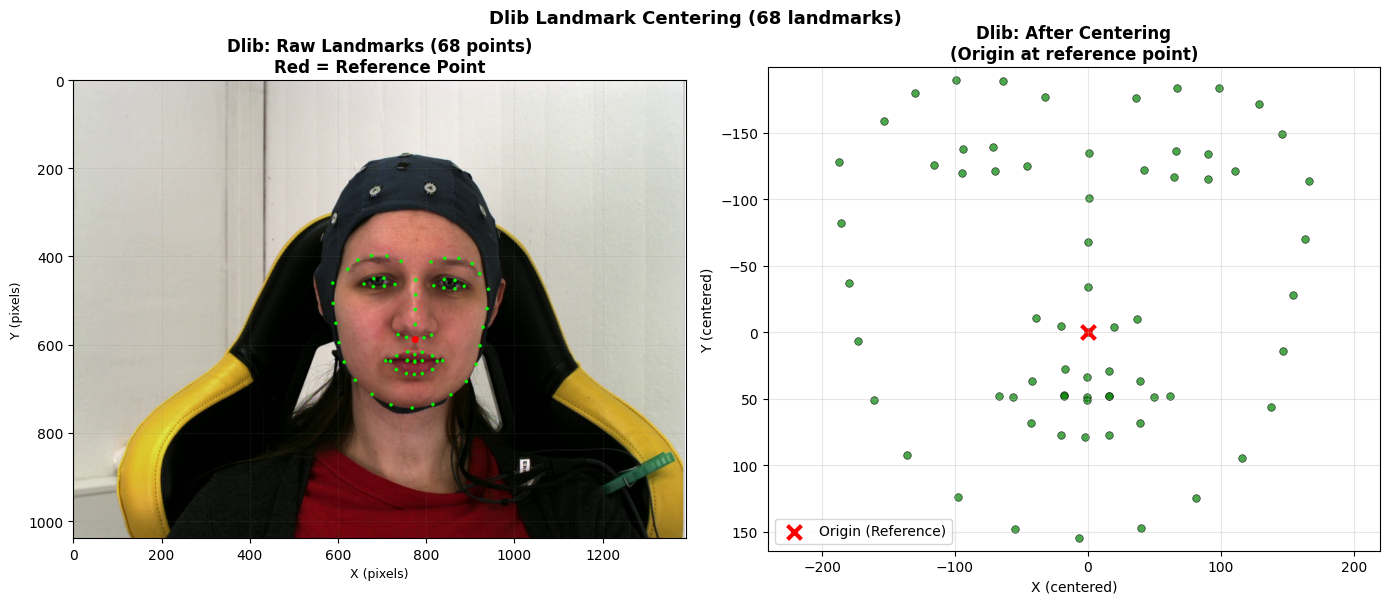

In [17]:
if dlib_raw is not None and dlib_centered is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Raw landmarks on image
    ax = axes[0]
    img_raw = sample_frame.copy()
    for (px, py) in dlib_raw.astype(int):
        cv2.circle(img_raw, (px, py), 4, (0, 255, 0), -1)
    # Mark reference point
    ref_pt = dlib_raw[33].astype(int)
    cv2.circle(img_raw, tuple(ref_pt), 8, (0, 0, 255), -1)

    ax.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    ax.set_title('Dlib: Raw Landmarks (68 points)\nRed = Reference Point',
                 fontsize=12, fontweight='bold')

    # Add grid to show coordinate system
    h, w = sample_frame.shape[:2]
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)  # Invert y-axis to match image coordinates
    ax.grid(True, alpha=0.2, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlabel('X (pixels)', fontsize=9)
    ax.set_ylabel('Y (pixels)', fontsize=9)

    # Centered landmarks in coordinate space
    ax = axes[1]
    ax.scatter(dlib_centered[:, 0], dlib_centered[:, 1],
               c='green', s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax.scatter(0, 0, c='red', s=100, marker='x', linewidth=3, label='Origin (Reference)')
    ax.invert_yaxis()

    ax.set_xlabel('X (centered)', fontsize=10)
    ax.set_ylabel('Y (centered)', fontsize=10)
    ax.set_title('Dlib: After Centering\n(Origin at reference point)',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.legend()

    plt.tight_layout()
    plt.suptitle('Dlib Landmark Centering (68 landmarks)', fontsize=13, fontweight='bold', y=1.00)
    plt.show()


#### MediaPipe

In [14]:
# Load MediaPipe reference keypoints
mp_ref_kp, mp_ref_ok = load_reference_keypoints(
    os.path.join(COLAB_ROOT, 'data', 'key_points_xyz.npy')
)
print("MediaPipe reference loaded:", mp_ref_ok)

# Create MediaPipe FaceMesh
face_mesh = create_face_mesh()

MediaPipe reference loaded: True


In [15]:
if face_mesh is not None:
    frame_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    mp_raw = parse_landmarks_from_results(results)

    if mp_raw is not None:
        mp_centered, mp_ref = center_keypoints(mp_raw, reference_index=2)
        print(f"✓ MediaPipe extraction successful")
        print(f"  Raw landmarks shape: {mp_raw.shape}")
        print(f"  Centered landmarks shape: {mp_centered.shape}")
        print(f"  Reference point: {mp_ref}")
    else:
        print("✗ No face detected by MediaPipe")
        mp_raw = None
        mp_centered = None
else:
    mp_raw = None
    mp_centered = None


✓ MediaPipe extraction successful
  Raw landmarks shape: (478, 3)
  Centered landmarks shape: (478, 3)
  Reference point: [ 0.5570696   0.5598169  -0.03130225]


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


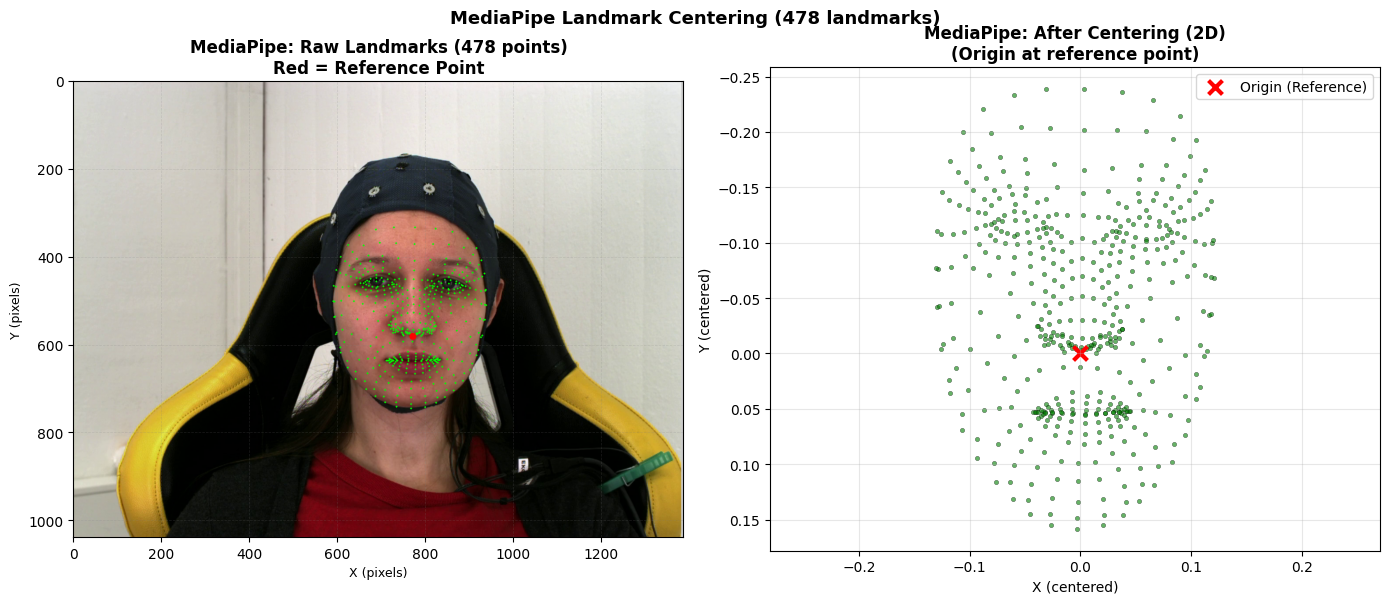

In [18]:
if mp_raw is not None and mp_centered is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Raw landmarks on image
    ax = axes[0]
    img_raw = sample_frame.copy()
    h, w = sample_frame.shape[:2]

    for lm in mp_raw:
        cx, cy = int(lm[0] * w), int(lm[1] * h)
        cv2.circle(img_raw, (cx, cy), 2, (0, 255, 0), -1)

    # Mark reference point
    ref_lm = mp_raw[2]
    rcx, rcy = int(ref_lm[0] * w), int(ref_lm[1] * h)
    cv2.circle(img_raw, (rcx, rcy), 8, (0, 0, 255), -1)

    ax.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    ax.set_title('MediaPipe: Raw Landmarks (478 points)\nRed = Reference Point',
                 fontsize=12, fontweight='bold')

    # Add grid to show coordinate system
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)  # Invert y-axis to match image coordinates
    ax.grid(True, alpha=0.2, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlabel('X (pixels)', fontsize=9)
    ax.set_ylabel('Y (pixels)', fontsize=9)

    # Centered landmarks in coordinate space (2D)
    ax = axes[1]
    ax.scatter(mp_centered[:, 0], mp_centered[:, 1],
              c='green', s=10, alpha=0.6, edgecolors='black', linewidth=0.3)
    ax.scatter(0, 0, c='red', s=100, marker='x', linewidth=3, label='Origin (Reference)')
    ax.invert_yaxis()
    ax.set_xlabel('X (centered)', fontsize=10)
    ax.set_ylabel('Y (centered)', fontsize=10)
    ax.set_title('MediaPipe: After Centering (2D)\n(Origin at reference point)',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.legend()

    plt.tight_layout()
    plt.suptitle('MediaPipe Landmark Centering (478 landmarks)', fontsize=13, fontweight='bold', y=1.00)
    plt.show()
